In [1]:
import os
import re
import time
from pathlib import Path
import shutil
import glob
import string
import unicodedata
from datetime import datetime, timedelta

import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.select import Select
from sqlalchemy import create_engine
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

from unicodedata import normalize, category

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stopset = set(stopwords.words("spanish"))

In [3]:
print(stopset)

{'habíais', 'estuvo', 'seríais', 'algunos', 'tendrías', 'tendremos', 'suyos', 'fuesen', 'tenían', 'con', 'nosotras', 'estar', 'esa', 'ni', 'somos', 'vosotros', 'estabais', 'seré', 'un', 'sería', 'estos', 'tuvimos', 'del', 'una', 'le', 'yo', 'habrás', 'habría', 'hayáis', 'habré', 'se', 'esto', 'seamos', 'entre', 'eres', 'tened', 'tu', 'tuvieran', 'tuviese', 'estuviesen', 'sentidos', 'nos', 'seas', 'tuviste', 'tengan', 'sentida', 'han', 'hay', 'nada', 'eran', 'fueran', 'teniendo', 'no', 'lo', 'estará', 'os', 'habrán', 'ese', 'vuestro', 'estabas', 'estuvieras', 'qué', 'hubo', 'estarían', 'fue', 'o', 'fueras', 'poco', 'muy', 'fuiste', 'hubieras', 'mí', 'tenida', 'que', 'era', 'quienes', 'tenemos', 'tuvieseis', 'tuvieras', 'más', 'tenido', 'eso', 'tuvisteis', 'hubieran', 'para', 'hayan', 'había', 'fueseis', 'es', 'tengas', 'suya', 'sois', 'vosotras', 'hubierais', 'tendríais', 'estéis', 'tendrían', 'seáis', 'estuvieran', 'tus', 'hayas', 'ante', 'por', 'fueses', 'hubieseis', 'estuviste', 'est

In [4]:
hoy = datetime.today()
hoy_format = hoy.strftime('%d%m%Y') 
hoy_format

'12092021'

In [5]:
for file in glob.iglob('news/{}/**/*.txt'.format(hoy_format), recursive=True):
    listado = file.replace('/', '\\').split('\\')
    
    if 'descartado' in listado:
        continue
        
    print(listado)
    with open(file, encoding='UTF-8') as f:
        new = f.read()
        
    break

['news', '12092021', 'original', 'bono-350-quienes-podran-cobrarlo-desde-el-13-de-septiembre-y-de-que-forma-bono-yanapay-peru-coronavirus-covi.txt']


In [6]:
from unicodedata import normalize, category

def clean_text_1(_text):
    """
        Ll : minusculas
        Zs : espacios
        Lu : mayusculas
        Nd : numeros
        Mn : tildes
        Ps : abre dieresis, .....
        Pe : cierra dieresis, .......
        Pi : abre parentesis, .....
        Po : cierra parentesis, punto, coma, .....        
        ...
    """
    selects_characters = ['Ll', 'Zs', 'Lu']
    
    return ''.join([_.lower() for _ in normalize('NFD', _text.replace(' ', 'ZZZ')) if category(_) in selects_characters])

### SIN QUITAR STOPWORDS

In [7]:
tokenizacion = [
    [clean_text_1(_) for _ in nltk.word_tokenize(sentence) if len(clean_text_1(_)) > 0] for sentence in nltk.sent_tokenize(new)
]

for oracion in tokenizacion:
    print(oracion)
    print("-"*100)

['desde', 'la', 'tercera', 'semana', 'de', 'setiembre', 'se', 'empezara', 'a', 'entregar', 'el', 'bono', 'soles']
----------------------------------------------------------------------------------------------------
['este', 'subsidio', 'tambien', 'conocido', 'como', 'yanapay', 'peru', 'tiene', 'como', 'objetivo', 'ser', 'una', 'ayuda', 'economica', 'para', 'aliviar', 'a', 'los', 'sectores', 'mas', 'vulnerables', 'ante', 'la', 'pandemia', 'de', 'coronavirus']
----------------------------------------------------------------------------------------------------
['este', 'bono', 'es', 'una', 'inyeccion', 'economica', 'universal', 'individualizada', 'que', 'a', 'diferencia', 'de', 'otros', 'subsidios', 'que', 'el', 'estado', 'ya', 'ha', 'venido', 'entregando', 'tiene', 'como', 'principal', 'caracteristica', 'que', 'sera', 'pagado', 'de', 'forma', 'personal', 'y', 'no', 'familiar']
----------------------------------------------------------------------------------------------------
['con', 'es

### QUITANDO STOPWORDS

In [8]:
stopset_cleaned = [clean_text_1(word) for word in stopset]
print(stopset_cleaned)

['habiais', 'estuvo', 'seriais', 'algunos', 'tendrias', 'tendremos', 'suyos', 'fuesen', 'tenian', 'con', 'nosotras', 'estar', 'esa', 'ni', 'somos', 'vosotros', 'estabais', 'sere', 'un', 'seria', 'estos', 'tuvimos', 'del', 'una', 'le', 'yo', 'habras', 'habria', 'hayais', 'habre', 'se', 'esto', 'seamos', 'entre', 'eres', 'tened', 'tu', 'tuvieran', 'tuviese', 'estuviesen', 'sentidos', 'nos', 'seas', 'tuviste', 'tengan', 'sentida', 'han', 'hay', 'nada', 'eran', 'fueran', 'teniendo', 'no', 'lo', 'estara', 'os', 'habran', 'ese', 'vuestro', 'estabas', 'estuvieras', 'que', 'hubo', 'estarian', 'fue', 'o', 'fueras', 'poco', 'muy', 'fuiste', 'hubieras', 'mi', 'tenida', 'que', 'era', 'quienes', 'tenemos', 'tuvieseis', 'tuvieras', 'mas', 'tenido', 'eso', 'tuvisteis', 'hubieran', 'para', 'hayan', 'habia', 'fueseis', 'es', 'tengas', 'suya', 'sois', 'vosotras', 'hubierais', 'tendriais', 'esteis', 'tendrian', 'seais', 'estuvieran', 'tus', 'hayas', 'ante', 'por', 'fueses', 'hubieseis', 'estuviste', 'est

In [9]:
tokenizacion = [
    [
        clean_text_1(_) for _ in nltk.word_tokenize(sentence) 
                     if len(clean_text_1(_)) > 0 and clean_text_1(_) not in stopset_cleaned
    ] for sentence in nltk.sent_tokenize(new)
]

for oracion in tokenizacion:
    if len(oracion) <= 0:
        continue

    print(oracion)
    print("-"*100)

['tercera', 'semana', 'setiembre', 'empezara', 'entregar', 'bono', 'soles']
----------------------------------------------------------------------------------------------------
['subsidio', 'conocido', 'yanapay', 'peru', 'objetivo', 'ser', 'ayuda', 'economica', 'aliviar', 'sectores', 'vulnerables', 'pandemia', 'coronavirus']
----------------------------------------------------------------------------------------------------
['bono', 'inyeccion', 'economica', 'universal', 'individualizada', 'diferencia', 'subsidios', 'venido', 'entregando', 'principal', 'caracteristica', 'pagado', 'forma', 'personal', 'familiar']
----------------------------------------------------------------------------------------------------
['subsidio', 'millones', 'personas', 'beneficiadas', 'peru']
----------------------------------------------------------------------------------------------------
['bono', 'otorgara', 'personas', 'mayores', 'edad', 'cuyos', 'ingresos', 'superen', 's', 'mensuales', 'formen', 'part

### AGREGANDO STEM

In [10]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')
stemmer

In [11]:
tokenizacion = [
    [
        stemmer.stem(clean_text_1(_)) for _ in nltk.word_tokenize(sentence) 
                     if len(clean_text_1(_)) > 0 and clean_text_1(_) not in stopset_cleaned
    ] for sentence in nltk.sent_tokenize(new)
]

for oracion in tokenizacion:
    if len(oracion) <= 0:
        continue

    print(oracion)
    print("-"*100)

['tercer', 'seman', 'setiembr', 'empez', 'entreg', 'bon', 'sol']
----------------------------------------------------------------------------------------------------
['subsidi', 'conoc', 'yanapay', 'peru', 'objet', 'ser', 'ayud', 'econom', 'alivi', 'sector', 'vulner', 'pandemi', 'coronavirus']
----------------------------------------------------------------------------------------------------
['bon', 'inyeccion', 'econom', 'universal', 'individualiz', 'diferent', 'subsidi', 'ven', 'entreg', 'principal', 'caracterist', 'pag', 'form', 'personal', 'famili']
----------------------------------------------------------------------------------------------------
['subsidi', 'millon', 'person', 'benefici', 'peru']
----------------------------------------------------------------------------------------------------
['bon', 'otorg', 'person', 'mayor', 'edad', 'cuy', 'ingres', 'super', 's', 'mensual', 'form', 'part', 'hogar', 'condicion', 'pobrez', 'pobrez', 'extrem', 'vulner', 'pais']
-------------

### LEMMATIZACION

In [12]:
#!pip install spacy                                  -- descomentar la 1era vez

In [13]:
#!pip install stanza                                 -- descomentar la 1era vez

In [14]:
#!pip install "spacy-stanza<0.3.0" --user            -- descomentar la 1era vez

In [15]:
import stanza

In [16]:
#stanza.download('es')                                -- descomentar la 1era vez

In [17]:
from spacy_stanza import StanzaLanguage

In [18]:
snlp = stanza.Pipeline(lang="es")
nlp = StanzaLanguage(snlp)

2021-09-12 10:04:46 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-09-12 10:04:46 INFO: Use device: cpu
2021-09-12 10:04:46 INFO: Loading: tokenize
2021-09-12 10:04:46 INFO: Loading: mwt
2021-09-12 10:04:46 INFO: Loading: pos
2021-09-12 10:04:46 INFO: Loading: lemma
2021-09-12 10:04:46 INFO: Loading: depparse
2021-09-12 10:04:47 INFO: Loading: ner
2021-09-12 10:04:48 INFO: Done loading processors!


In [28]:
tokenizacion = [
    [
       ''.join([token.lemma_ for token in nlp(clean_text_1(_))]) for _ in nltk.word_tokenize(sentence) 
                     if len(clean_text_1(_)) > 0 and clean_text_1(_) not in stopset_cleaned
    ] for sentence in nltk.sent_tokenize(new)
]

for oracion in tokenizacion:
    if len(oracion) <= 0:
        continue

    print(oracion)
    print("-"*100)

['tercero', 'semana', 'setiembre', 'empezar', 'entregar', 'bono', 'sol']
----------------------------------------------------------------------------------------------------
['subsidio', 'conocido', 'yanapar', 'peru', 'objetivo', 'ser', 'ayuda', 'economico', 'aliviar', 'sector', 'vulnerable', 'pandemia', 'coronaviru']
----------------------------------------------------------------------------------------------------
['bono', 'inyeccion', 'economico', 'universal', 'individualizado', 'diferencia', 'subsidio', 'venir', 'entregar', 'principal', 'caracteristica', 'pagado', 'forma', 'personal', 'familiar']
----------------------------------------------------------------------------------------------------
['subsidio', 'millón', 'persona', 'beneficiado', 'peru']
----------------------------------------------------------------------------------------------------
['bono', 'otorgar', 'persona', 'mayor', 'edad', 'cuyo', 'ingreso', 'superar', 's', 'mensual', 'formar', 'parte', 'hogar', 'condicion

### POS TAGGING

In [30]:
tokenizacion = [
    [
       [(token.pos_, token.tag_) for token in nlp(clean_text_1(_))][0] for _ in nltk.word_tokenize(sentence) 
                     if len(clean_text_1(_)) > 0 and clean_text_1(_) not in stopset_cleaned
    ] for sentence in nltk.sent_tokenize(new)
]

for oracion in tokenizacion:
    if len(oracion) <= 0:
        continue

    print(oracion)
    print("-"*100)

[('ADJ', 'Gender=Fem|NumType=Ord|Number=Sing'), ('NOUN', 'Gender=Fem|Number=Sing'), ('NOUN', 'AdvType=Tim'), ('VERB', 'Mood=Sub|Number=Sing|Person=3|Tense=Imp|VerbForm=Fin'), ('VERB', 'VerbForm=Inf'), ('NOUN', 'Gender=Masc|Number=Sing'), ('NOUN', 'Gender=Masc|Number=Plur')]
----------------------------------------------------------------------------------------------------
[('NOUN', 'Gender=Masc|Number=Sing'), ('ADJ', 'Gender=Masc|Number=Sing|VerbForm=Part'), ('VERB', 'Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin'), ('NOUN', 'Gender=Masc|Number=Sing'), ('NOUN', 'Gender=Masc|Number=Sing'), ('AUX', 'VerbForm=Inf'), ('NOUN', 'Gender=Fem|Number=Sing'), ('ADJ', 'Gender=Fem|Number=Sing'), ('VERB', 'VerbForm=Inf'), ('NOUN', 'Gender=Masc|Number=Plur'), ('ADJ', 'Number=Plur'), ('NOUN', 'Gender=Fem|Number=Sing'), ('NOUN', 'Gender=Masc')]
----------------------------------------------------------------------------------------------------
[('NOUN', 'Gender=Masc|Number=Sing'), ('NOUN', 'Ge

Graficando

In [33]:
conteo = {}

pos = [
    [
       [token.pos_ for token in nlp(clean_text_1(_))][0] for _ in nltk.word_tokenize(sentence) 
                     if len(clean_text_1(_)) > 0 and clean_text_1(_) not in stopset_cleaned
    ] for sentence in nltk.sent_tokenize(new)
]

for secuencia in pos:
    for pos_ in secuencia:
        if pos_ not in conteo:
            conteo[pos_] = 1
        else:
            conteo[pos_] += 1
            
            
conteo

{'ADJ': 27,
 'NOUN': 95,
 'VERB': 36,
 'AUX': 5,
 'PRON': 3,
 'NUM': 1,
 'DET': 1,
 'PUNCT': 2,
 'ADP': 2,
 'ADV': 1}

<AxesSubplot:ylabel='pos'>

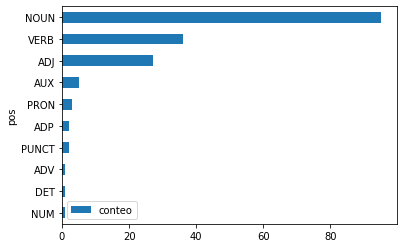

In [45]:
df = pd.DataFrame(conteo.items())
df.columns = ['pos', 'conteo']
df = df.sort_values(by=['conteo'], ascending=True)
df = df.set_index('pos')
df.plot(kind='barh')